# 5. Descomposición de datos y técnicas de análisis
## 5.3. Análisis de clúster

El objetivo del análisis de clúster es encontrar subgrupos o clústers en un conjunto de datos. Al agrupar las observaciones, buscamos una *partición* tal que las observaciones *dentro* de cada grupo sean lo màs similares entre sí que entre grupos diferentes.

El análisis de clúster también es usado como una forma de estadística descriptiva para asegurarse de que los datos realmente consisten en distintos subgrupos.

Por ejemplo, suponer que tenemos un conjunto de $n$ observaciones, cada una con $p$ características. Las observaciones pueden corresponder al tejido de $n$ pacientes con cáncer, y las $p$ características a mediciones de cada tejido (e.g., estadío del tumor o expresión de genes). Tenemos razones para creer que existen diferentes subtipos de cáncer *desconocidos*. Podemos usar análisis de clúster para encontrar esos subtipos.

Otro uso podría ser en marketing. Por ejemplo, podríamos tener datos como ingreso promedio, ocupación, distancia con respecto a área urbana, etc., para una $n$ grande. Con estos datos, podríamos realizar una segmentación de mercado identificando subgrupos de personas que podrían ser más receptivas a una forma particular de publicidad o más probables de comprar un producto.

Es un problema *no supervisado* porque tratamos de encontrar una estructura en los datos, no realizar predicciones de observaciones. 

### 5.3.1. K-Means

El propósito del K-means es segmentar las observaciones en un número especificado $K$ de clústers. Luego, el algoritmo que usemos asignará una observación a exactamente un clúster. 


Sea $C_1, \dots, C_K$ conjuntos que contienen los *índices* de las observaciones en cada cluster. Por ejemplo, si el clúster 1 contiene 12 observaciones, $C_1 = \{1,\dots, 12\}$. Los conjuntos deben satisfacer las siguientes dos propiedades:

1. $C_1 \cup C_2 \cup \dots \cup C_k = \{1, 2, \dots, n\}$. Cada observación pertenece a al menos un $K$ clúster.
2. $C_1 \cap C_2 \cap \dots \cap C_k = \emptyset,\quad \forall k \neq k'$. Es decir, los clúster no se sobreponen: ninguna observación puede pertenecer a más de un clúster.

El K-means es un algoritmo de clústering *duro*. Existen otros algoritmos en donde la segmentación es suave (soft clustering). En ese caso, una observación puede pertenecer a dos clúster con diferente probabilidad.


Una buena segmentación es aquella para la cuál la variación *dentro del clúster* es mínima. La variación intra-clúster $C_k$ es una medida $W(C_k)$, y es la cantidad para la cual las observaciones dentro de un clúster difieren una de otra. 

$$
  \min_{C_1,\dots, C_k } \left \{ \sum_{k=1}^K W(C_k) \right \}\tag{1}
$$

En otras palabras, vamos a realizar una partición de los $n$ datos en $K$ clústers tal que la variación intraclúster $W(C_k)$ sea mínima. Por lo tanto, necesitamos definir $W(C_k)$. Una forma popular de definirla es como la distancia cuadrática Euclidiana

$$
  W(C_k) = \frac{1}{\mid C_k \mid} \sum_{i, i'\in C_k}\sum_{j=1}^p(x_{ij}-x_{i'j})^2\tag{2}
$$

En donde $\mid C_k \mid$ es el número de observaciones en el $k$ clúster. En otras palabras, $W(C_k)$ es la suma de todas las distancias euclidianas cuadráticas por parejas entre las observaciones en el $k$ clúster, dividida por el número de las observaciones.

El problema es entonces

$$
  \min_{C_1,\dots, C_k } \left \{ \sum_{k=1}^K \frac{1}{\mid C_k \mid} \sum_{i, i'\in C_k}\sum_{j=1}^p(x_{ij}-x_{i'j})^2 \right \}\tag{3}
$$

In [12]:
# cargar algunas funciones que se utilizarán
source("../r_scripts/utilities.r")
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


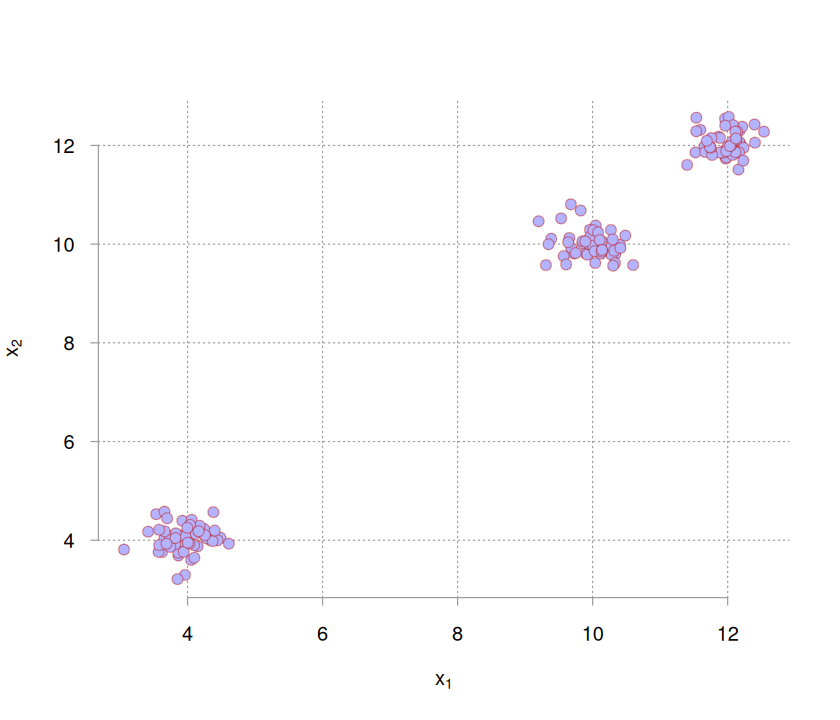

In [86]:
options(repr.plot.width = 7, repr.plot.height = 6)
x <- rbind(
  matrix(rnorm(100, mean = 4, sd = 0.3), ncol = 2),
  matrix(rnorm(100, mean = 12, sd = 0.3), ncol = 2),
  matrix(rnorm(100, mean = 10, sd = 0.3), ncol = 2)
)

scatter_plot(
  x[, 1], x[, 2],
  # dos formas diferentes de anotaciones matemáticas
  xlab = parse(text = "x[1]"), ylab = expression(x[2]),
  color = red_light, fill = blue_light
)

df_xbiv <- data.frame(x1 =  x[, 1], x2 =  x[, 2])
write.csv(df_xbiv, 'cluster_bivariado.csv', row.names = FALSE)


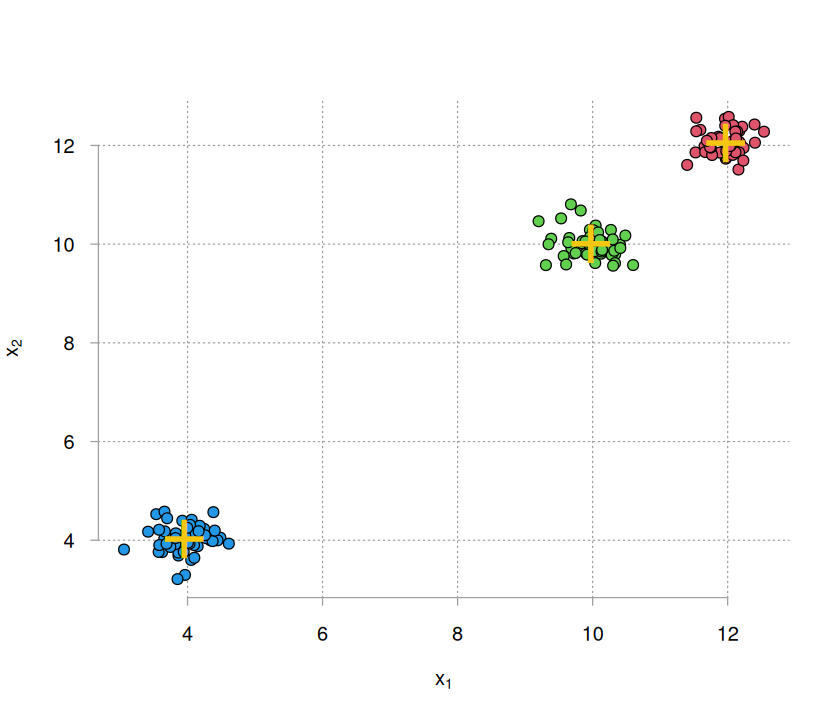

In [90]:
km3 <- kmeans(x, 3, iter.max = 2000, nstart = 3)
df_xbiv$cls <- km3$cluster

scatter_plot(
  x[, 1], x[, 2],
  # dos formas diferentes de anotaciones matemáticas
  xlab = parse(text = "x[1]"), ylab = expression(x[2]),
  color = 1, fill = df_xbiv$cls+1
)
points(km3$centers[,1], km3$centers[,2], pch = '+', cex = 4, col = 7)